In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import the salinization wetland dataset
peat_cols = ['decday', 'datetime', 'wm_gf', 'wm', 'wc_gf', 'gpp_ANNnight', 'er_ANNnight', 'wq_gf', 'TA.y', 'sal', 'PAR', 'VPD', 'PA.x', 
         'PRECIP', 'ustar', 'WT', 'H_gf', 'TW_WATER_10cm']

peat = pd.read_csv('data/peat6_all.csv', usecols=peat_cols, index_col='datetime', parse_dates=True)

In [337]:
def entropy(x, bins = 10):
    
    counts = x.value_counts(bins = bins)
    probs = counts / np.sum(counts)
    
    return - np.sum(probs * np.log2(probs))

def joint_entropy(x, y, bins = 10):
    
    x.reset_index(drop = True, inplace = True)
    y.reset_index(drop = True, inplace = True)
    combined = pd.concat([x, y], axis=1).dropna() #drop all rows with NA in both variables
    
    j_probs = pd.crosstab(pd.cut(combined.iloc[:, 0], bins = bins), 
                          pd.cut(combined.iloc[:, 1], bins = bins)) / len(combined)

    return - np.sum(np.sum(j_probs * np.log2(j_probs)))

def entropy_3d(x, y, z, bins = 10):
    
    x.reset_index(drop = True, inplace = True)
    y.reset_index(drop = True, inplace = True)
    z.reset_index(drop = True, inplace = True)
    combined = pd.concat([x, y, z], axis = 1).dropna()
    
    j_probs = pd.crosstab(pd.cut(combined.iloc[:, 0], bins = bins),
                          [pd.cut(combined.iloc[:, 1], bins = bins),
                           pd.cut(combined.iloc[:, 2], bins = bins)]) / len(combined)
    
    return - np.sum(np.sum(j_probs * np.log2(j_probs)))

def mutual_information(x, y, bins = 10, normalize = True):
    
    Hx = entropy(x, bins = bins)
    Hy = entropy(y, bins = bins)
    Hxy = joint_entropy(x, y, bins = bins)
    
    if normalize == True:
        MI = (Hx + Hy - Hxy) / Hy
    else:
        MI = Hx + Hy - Hxy
        
    return MI

def transfer_entropy(x, y, xlag, ylag = 1, bins = 10, normalize = True):
    
    #lag x and y variables
    x_lagged = x.shift(xlag).rename('x_lagged')
    y_lagged = y.shift(ylag).rename('y_lagged')
    
    #calculate joint and marginal entropies for transfer entropy calculation
    Hxy = joint_entropy(x_lagged, y_lagged, bins = bins)
    Hyy = joint_entropy(y, y_lagged, bins = bins)
    Hyl = entropy(y_lagged, bins = bins)
    Hxyz = entropy_3d(x_lagged, y_lagged, y, bins = bins)
    Hy = entropy(y, bins = bins)
    
    if normalize == True:
        TE = (Hxy + Hyy - Hyl - Hxyz) / Hy
    else:
        TE = Hxy + Hyy - Hyl - Hxyz
    
    return TE 

def lag_TE(x, y, lags, bins = 10, normalize = True):
    
    lagged_out = [transfer_entropy(x, y, xlag = (i + 1), bins=bins, ylag=1, normalize=normalize) for i in range(lags)]
    
    return pd.Series(lagged_out)

In [530]:
def MI_timeseries(x_var, y_var, bins = 10, normalize = True,
                  runs = 100, alpha = 0.05, MC_runs = True):
    
    #combine variables and create monthly stamp
    combined = pd.concat([x_var, y_var], axis=1).dropna()
    combined['Yr_mnth'] = combined.index.strftime('%Y%m')
    cols = combined.columns
    
    #subset data my month, calculate and save mutual information
    time_index = combined['Yr_mnth'].unique()
    MI_out = np.empty(len(time_index)) #empty MI array
    
    if MC_runs == True:
        MI_MC = np.empty([len(time_index), runs]) #raw MC runs matrix
    
    for i in range(len(time_index)):
        
        monthly = combined[combined.Yr_mnth == time_index[i]]
        MI_out[i] = mutual_information(monthly[cols[0]], monthly[cols[1]], 
                                       bins = bins, normalize=normalize)
        
        if MC_runs == True:
            
            for j in range(runs):
                x_shuffle = monthly[cols[0]].sample(len(monthly), replace = False) #shuffle x
                
                MI_MC[i, j] = mutual_information(x_shuffle, monthly[cols[1]], 
                                                 bins = bins, normalize = normalize)         
    
    if MC_runs == True:
        MI_MC = np.percentile(MI_MC, q = (1 - alpha) * 100, axis = 1)                
        return MI_out, MI_MC
    
    return MI_out

def TE_timeseries(x_var, y_var, lags, bins=10, normalize = True,
                  runs = 10, alpha = 0.05, MC_runs = True):
    
    #remove NAs and subset growing season only data (DOY 100-300)
    combined = pd.concat([x_var, y_var], axis = 1).dropna()
    combined = combined[(combined.index.dayofyear > 100) & (combined.index.dayofyear < 300)]
    cols = combined.columns
    
    #iterate across each years growing season
    year = combined.index.year.unique()
    TE_out = np.empty([lags, len(year)])
    
    if MC_runs == True:
        TE_MC = np.empty([lags, len(year), runs])
    
    for i in range(len(year)):
        
        subset = combined[combined.index.year == year[i]]
        TE_out[:, i] = lag_TE(subset[cols[0]], subset[cols[1]], lags=lags, bins=bins, normalize=normalize)
        
        if MC_runs == True:
            
            for j in range(runs):
                x_shuffle = subset[cols[0]].sample(len(subset), replace = False) #shuffle x variable
                
                TE_MC[:, i, j] = lag_TE(x_shuffle, subset[cols[1]], lags=lags, bins=bins, normalize=normalize)
    
    if MC_runs == True:
        TE_MC = pd.DataFrame(np.percentile(TE_MC, q = (1 - alpha) * 100, axis = 2), 
                             columns=combined.index.year.unique())
        
    TE_out = pd.DataFrame(TE_out, columns=combined.index.year.unique())
    TE_out.index = TE_out.index + 1
    
    return TE_out, TE_MC

In [298]:
obs = peat['2012':'2017']
GPP_mi, GPP_mc = MI_timeseries(obs['gpp_ANNnight'], obs['wm'], MC_runs = True, runs = 10)
TA_mi, TA_mc = MI_timeseries(obs['TA.y'], obs['wm'], MC_runs = True, runs = 10)

/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  


Text(0.5,0,'Time')

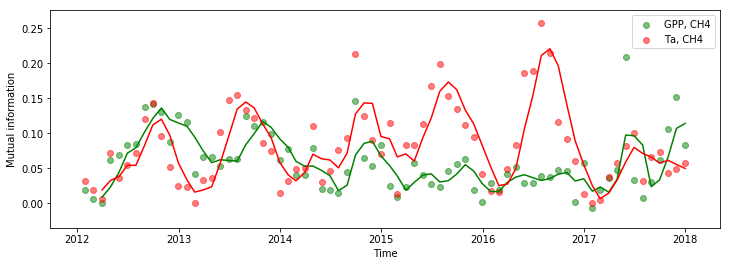

In [299]:
## Figure 1 in python
time = pd.date_range('2012', '2018', freq = 'M') #create time stamp

#corrected MI
GPP_mi_c = (GPP_mi - GPP_mc)
TA_mi_c = (TA_mi - TA_mc)

#plot it!
fig = plt.figure(figsize=(12, 4))
plt.scatter(time, GPP_mi_c, alpha = 0.5, color = 'green', label = 'GPP, CH4')
plt.scatter(time, TA_mi_c, alpha = 0.5, color = 'red', label = 'Ta, CH4')
plt.plot(time, pd.Series(GPP_mi_c).rolling(3).mean(), color = 'green')
plt.plot(time, pd.Series(TA_mi_c).rolling(3).mean(), color = 'red')
plt.legend()
plt.ylabel('Mutual information')
plt.xlabel('Time')


In [531]:
def anomaly_filter(x, window = 5):
    return x - x.rolling(window).mean()

anom_data = peat.copy()
anom_data['time_o_day'] = anom_data.index.round('min').strftime('%H:%M')
anom_data = anom_data.sort_values(['time_o_day', 'decday']) #sort to adjacent half hours

#anomaly filter variables
anom_data['CH4_anom'] = anomaly_filter(anom_data['wm_gf'])
anom_data['GEP_anom'] = anomaly_filter(anom_data['gpp_ANNnight'])
anom_data['Ta_anom'] = anomaly_filter(anom_data['TA.y'])

anom_data.sort_index(inplace=True) #resort into linear time

anom_data = anom_data['2012':'2016']
anom_data = anom_data[~(anom_data.index.year == 2014)]

TA_te, TA_sig = TE_timeseries(anom_data['Ta_anom'], anom_data['CH4_anom'], 120, runs=5)
GPP_te, GPP_sig = TE_timeseries(anom_data['GEP_anom'], anom_data['CH4_anom'], 120, runs=5)

/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log2
/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log2
/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  


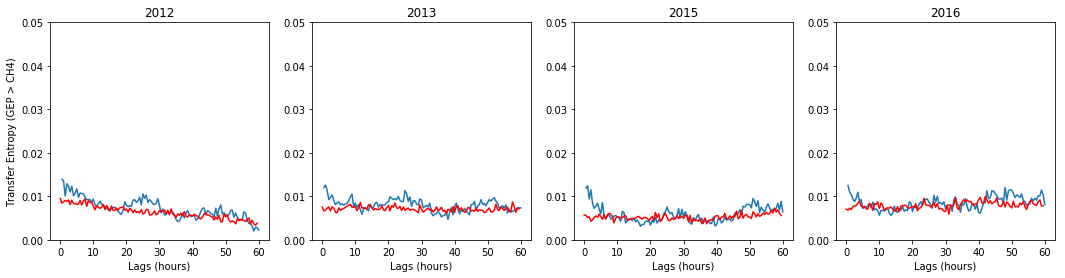

In [547]:
years = sub.index.year.unique()
fig, ax = plt.subplots(1, len(years), figsize=(18, 4))

for i in range(len(years)):
    ax[i].plot(GPP_te.index/2, GPP_te.iloc[:, i])
    ax[i].plot(GPP_sig.index/2, GPP_sig.iloc[:, i], color='red')
    ax[i].set_ylim(0, 0.05)
    ax[i].set_title(TA_te.columns[i])
    ax[i].set_xlabel('Lags (hours)')
    ax[0].set_ylabel('Transfer Entropy (GEP > CH4)')

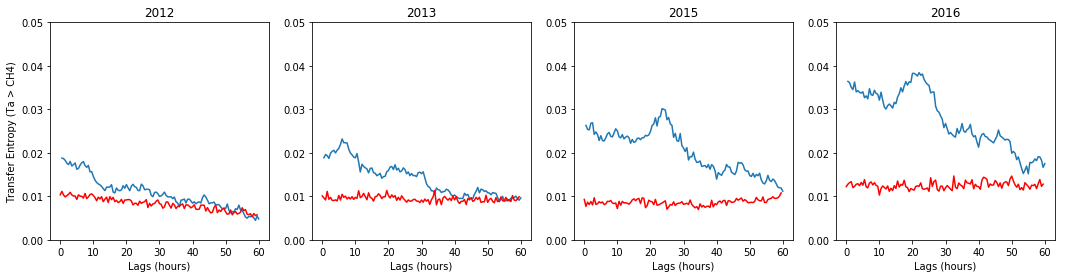

In [548]:
years = sub.index.year.unique()
fig, ax = plt.subplots(1, len(years), figsize=(18, 4))

for i in range(len(years)):
    ax[i].plot(TA_te.index/2, TA_te.iloc[:, i])
    ax[i].plot(TA_sig.index/2, TA_sig.iloc[:, i], color='red')
    ax[i].set_ylim(0, 0.05)
    ax[i].set_title(TA_te.columns[i])
    ax[i].set_xlabel('Lags (hours)')
    ax[0].set_ylabel('Transfer Entropy (Ta > CH4)')

In [544]:
TA_te.columns[0]

2012

In [533]:
GPP_sig

datetime,2012,2013,2015,2016
0,0.009530,0.007527,0.005690,0.007045
1,0.008424,0.006617,0.005603,0.006813
2,0.008703,0.006861,0.005153,0.007279
3,0.009060,0.007281,0.005276,0.006952
4,0.008820,0.007545,0.004273,0.007637
5,0.009149,0.006666,0.004585,0.007775
6,0.008091,0.007603,0.005177,0.007874
7,0.009101,0.007234,0.005474,0.008388
8,0.008385,0.006344,0.005189,0.008856
9,0.008263,0.006235,0.005917,0.007769


In [555]:
anom_data['test'] = np.where(anom_data['wm'].isnull(), np.nan, anom_data['CH4_anom'])

In [556]:
anom_data.head(100)

,decday,PA.x,ustar,wm,H_gf,wq_gf,wc_gf,wm_gf,er_ANNnight,gpp_ANNnight,...,PAR,WT,TW_WATER_10cm,VPD,sal,time_o_day,CH4_anom,GEP_anom,Ta_anom,test
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,731.0000,102.4,0.123120,NaN,0.15685,0.127480,0.439700,24.02420,2.1531,-1.713400,...,0.0000,114.6897,9.275,0.078042,NaN,00:00,-4.821500,-0.363790,-2.5448,NaN
2012-01-01 00:29:57,731.0208,102.4,0.097564,NaN,-0.98176,0.055194,0.591990,23.85540,2.2558,-1.663800,...,0.0000,114.6894,9.125,0.073259,NaN,00:30,-3.875040,-0.469622,-2.4026,NaN
2012-01-01 01:00:02,731.0417,102.4,0.109020,NaN,-0.28489,0.059639,0.597560,24.26030,2.2340,-1.636400,...,0.0000,114.6892,9.110,0.047779,NaN,01:00,-33.318980,-0.361593,-2.4842,NaN
2012-01-01 01:30:00,731.0625,102.4,0.094842,NaN,0.18619,0.012596,0.550320,23.65570,2.4085,-1.858200,...,0.0000,114.6890,8.975,0.043181,NaN,01:30,1.502620,-0.479596,-2.7938,NaN
2012-01-01 01:59:57,731.0833,102.4,0.126170,NaN,0.33605,0.010254,0.555450,22.97800,2.1803,-1.624900,...,0.0000,114.6888,8.905,0.035808,NaN,02:00,3.554720,-0.289104,-2.7692,NaN
2012-01-01 02:30:02,731.1042,102.5,0.121040,NaN,1.52690,-0.010793,0.505800,23.16540,2.1266,-1.620800,...,0.0000,114.6885,8.780,0.028723,NaN,02:30,1.808740,-0.099760,-3.2262,NaN
2012-01-01 03:00:00,731.1250,102.5,0.134670,NaN,2.35300,0.004616,0.523820,23.07570,2.0805,-1.556700,...,0.0000,114.6883,8.655,0.024489,NaN,03:00,-3.276780,-0.269552,-3.1868,NaN
2012-01-01 03:29:57,731.1458,102.4,0.157820,NaN,11.14490,0.193750,0.644980,25.26390,2.1192,-1.474200,...,0.0000,114.6881,8.590,0.022883,NaN,03:30,-0.780440,-0.085416,-3.3660,NaN
2012-01-01 04:00:02,731.1667,102.5,0.188960,NaN,31.24610,0.260390,0.612160,25.49650,2.0503,-1.438200,...,0.0000,114.6878,8.460,0.022666,NaN,04:00,-1.252420,-0.248722,-3.2264,NaN
